**Getting started:** This notebook relies on the [casingSimulations](http://casingresearch.readthedocs.io) repository. It can be installed using
```
pip install git+https://github.com/lheagy/casingSimulations.git
```

In [1]:
# !pip install git+https://github.com/lheagy/casingSimulations.git

# Anatomy of a TDEM casing response

- background resistivity average is 10 Ωm
- well is 1km long has a 20cm diameter, 1cm thickness. Its conductivity is $5.5 \times 10^6$ S/m and a permeability of 100 $\mu_0$
- return Electrode: 1000m from the wellhead
- two experiments: top casing and down-hole (at z=-975m) sources 

In [2]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pymatsolver import Pardiso

import casingSimulations

%matplotlib inline

Two experiments are considered, 
- `topcasing` experiment: the positive electrode is connected to the top of the casing
- `downhole` experiment: the positive electrode is coupled to the casing down-hole at z=-975m

In [3]:
simDirs = {
    "topcasing": "1km_well_10ohm_m_TDEM_airn4_topcasing",
    "downhole": "1km_well_10ohm_m_TDEM_airn4_downhole"
}

# Load up 3D results

Load the saved properties and fields. 

In [4]:
sim3Dtopcasing = casingSimulations.utils.loadSimulationResults(
    directory = simDirs["topcasing"]
)

Loading simulation in 1km_well_10ohm_m_TDEM_airn4_topcasing
   loading fields
  repopulating fields
   ... Done. Elapsed time : 10.3620941639



In [5]:
sim3Ddownhole = casingSimulations.utils.loadSimulationResults(
    directory = simDirs["downhole"], 
    meshGenerator=sim3Dtopcasing.meshGenerator
)

Loading simulation in 1km_well_10ohm_m_TDEM_airn4_downhole
   loading fields
  repopulating fields
   ... Done. Elapsed time : 11.791205883



In [6]:
simDCtopcasing = casingSimulations.utils.loadSimulationResults(
    directory = simDirs["topcasing"],
    simulationParameters="SimulationDC.json",
    fields="fieldsDC.npy",
    meshGenerator=sim3Dtopcasing.meshGenerator
)

simDCdownhole = casingSimulations.utils.loadSimulationResults(
    directory = simDirs["downhole"],
    simulationParameters="SimulationDC.json",
    fields="fieldsDC.npy",
    meshGenerator=sim3Dtopcasing.meshGenerator
)

Loading simulation in 1km_well_10ohm_m_TDEM_airn4_topcasing
   loading fields
  repopulating fields
   ... Done. Elapsed time : 10.3634278774

Loading simulation in 1km_well_10ohm_m_TDEM_airn4_downhole
   loading fields
  repopulating fields
   ... Done. Elapsed time : 10.2980949879



## print parameters

In [7]:
fields3Dtopcasing = sim3Dtopcasing.fields()
fields3Ddownhole = sim3Ddownhole.fields()

In [8]:
print(sim3Dtopcasing.modelParameters)


 ---- Survey ---- 

   src_a: [ 0.          3.14159265  0.        ]
   src_b: [ 1000.             3.14159265     0.        ]

   100 time steps. min time step: 1.0e-06 s, max time step: 1.0e-01 s. Total time: 1.2e+00 s


 ---- Model ---- 

  background: 
    - conductivity: 1.0e-01 S/m
    - permeability: 1.0 \mu_0

  air: 
    - conductivity: 1.0e-04 S/m
    - earth surface elecation: 0.0 m


 ---- Casing ---- 

  properties: 
    - conductivity: 5.5e+06 S/m
    - permeability: 100.0 \mu_0
    - conductivity inside: 1.0e+00 S/m

  geometry: 
    - casing top: 0.0 m
    - casing length: 1000.0 m
    - casing diameter: 2.0e-01 m
    - casing thickness: 1.0e-02 m


### Mesh

In [ ]:
# plot the model


In [ ]:
# plot the source

In [15]:
# simulations = {
#     '3D':{},
#     '2D':{},
#     'DC':{}
# }

# fields = {
#     '3D':{},
#     '2D':{},
#     'DC':{}
# }

# for dim in enumerate(['3D', '2D', 'DC']):
#     for key, simDir in simDirs.items():
#         simulation = casingSimulations.load_properties(
#             '/'.join([simDir, 'simulationParameters.json'])
#         )
#         solution = np.load('/'.join([simDir, 'fields.npy']))
#         field = simulation.prob.fieldsPair(meshGen.mesh, sim3D.survey)
#         field[:, simulation.formulation+'Solution'] = solution
#         simulation._fields = field
        
#         fields[dim][key] = field
#         simulations[dim][key] = simulation
    

IOError: [Errno 2] No such file or directory: '1km_well_10ohm_m_TDEM_airn4_topcasing/simulationParameters.json'

In [108]:
meshGen = casingSimulations.load_properties('/'.join([simDir, 'MeshParameters.json']))
cp = casingSimulations.load_properties('/'.join([simDir, 'ModelParameters.json']))
jfield = np.load('/'.join([simDir, 'fields.npy']))

src = casingSimulations.load_properties('/'.join([simDir, 'Source.json'])) #, targetModule=casingSimulations.sources)
simulation = casingSimulations.load_properties(
    '/'.join([simDir, 'simulationParameters.json']), 
    #targetClass=casingSimulations.run.SimulationTDEM
)

In [109]:
# Recreate the sim3D instance
sim3D = casingSimulations.run.SimulationTDEM(modelParameters=cp, meshGenerator=meshGen, src=src)
sim3D.prob.model = sim3D.physprops.model

In [110]:
%%time
# recreate the fields object
fields3D = sim3D.prob.fieldsPair(meshGen.mesh, sim3D.survey)

CPU times: user 3min 39s, sys: 6.24 s, total: 3min 45s
Wall time: 3min 56s


In [111]:
fields3D[:,'jSolution'] = jfield
srcList = sim3D.survey.srcList

In [112]:
cylmesh = meshGen.mesh
src = sim3D.src

In [113]:
fields3D.aliasFields

{'dhdt': ['jSolution', 'E', '_dhdt'], 'j': ['jSolution', 'F', '_j']}

In [114]:
# Load up 2D and DC results
jfield2D = np.load('/'.join([simDir, 'fields2D.npy']))
phiDC = np.load('/'.join([simDir, 'fieldsDC.npy']))

In [115]:
# recreate 2D simulation

mesh2D = sim3D.meshGenerator.copy()
mesh2D.hy = np.r_[2*np.pi]
src2D = getattr(casingSimulations.sources, sim3D.src.__class__.__name__)(
    modelParameters=sim3D.modelParameters,
    meshGenerator=mesh2D,
)
sim2D = casingSimulations.run.SimulationTDEM(
    modelParameters=sim3D.modelParameters,
    meshGenerator=mesh2D,
    src=src2D,
    fields_filename='fields2D.npy',
    filename='simulation2D.json'
)

In [116]:
# recreate DC simulation

csz = sim3D.meshGenerator.csz
# make sure it is in the cell
src_a = sim3D.src.src_a_closest - np.r_[0., 0., csz/2.]
src_b = sim3D.src.src_b_closest - np.r_[0., 0., csz/2.]

simDC = casingSimulations.run.SimulationDC(
    filename='simulationDC.py',
    modelParameters=sim3D.modelParameters,
    meshGenerator=sim3D.meshGenerator,
    src_a=src_a,
    src_b=src_b
)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [117]:
# put model back on fields

sim2D.prob.model = sim2D.physprops.model
simDC.prob.model = simDC.physprops.model

In [118]:
%%time
fields2D = sim2D.prob.fieldsPair(sim2D.meshGenerator.mesh, sim2D.survey)

CPU times: user 132 ms, sys: 32 ms, total: 164 ms
Wall time: 218 ms


In [119]:
%%time
fieldsDC = simDC.prob.fieldsPair(simDC.meshGenerator.mesh, simDC.survey)

CPU times: user 1.66 s, sys: 641 ms, total: 2.3 s
Wall time: 2.61 s


In [120]:
fields2D[:,'jSolution'] = jfield2D
fieldsDC[:,'phiSolution'] = phiDC

# Plot the Results

In [121]:
import ipywidgets

In [122]:
mesh2Dplt = sim3D.meshGenerator.create_2D_mesh().mesh

In [175]:
def plotCurrents(tind=0, theta_ind=0, simulation='3D', ax=None, plotopts={}):
        
    assert simulation in ['3D', '2D', 'DC']
    
    if simulation == '3D': 
        jfull = fields3D[:,'j',tind]
        jplt = casingSimulations.face3DthetaSlice(meshGen.mesh, jfull, theta_ind=theta_ind)
    
    elif simulation == '2D':
        jplt = fields2D[:, 'j', tind]
    
    elif simulation == 'DC':
        jdc = fieldsDC[:, 'j']
        jplt = casingSimulations.face3DthetaSlice(meshGen.mesh, jdc, theta_ind=theta_ind)

    if ax is None: 
        fig, ax = plt.subplots(1,1, figsize=(6, 7))
    
    casingSimulations.plotFace2D(
        mesh2Dplt,
        jplt, real_or_imag='real', ax=ax, **plotopts
    )
    ax.set_title('j {} at t={}s, theta={:1.1f}'.format(
        simulation, sim2D.prob.times[tind], meshGen.mesh.vectorCCy[theta_ind]*180/np.pi
    ))
    return ax

### Set up parameters for looking near the well or deeper into the reservoir

In [176]:
plotopts_far = {
    'range_x':np.r_[0., 1200.],
    'range_y':np.r_[-1500., 0.], 
    'sample_grid':np.r_[10., 10.],
    'logScale':True, 
    'clim':[1e-9, 1e-4], 
    'mirror':False
}

plotopts_close = {
    'range_x':np.r_[0, 0.4],
    'range_y':np.r_[-1300., 0.], 
    'sample_grid':np.r_[0.01, 10.],
    'logScale':True, 
    'clim':[1e-9, 1e-1], 
    'mirror':False
}

In [180]:
def interact_currents(tind, theta_ind, simulation, view):
    plotCurrents(
        tind, theta_ind, simulation, None,
        plotopts_close if view == "close" else plotopts_far if view=="far" else None
    )
    plt.show()
    
ipywidgets.interact(
    interact_currents,
    tind=ipywidgets.IntSlider(min=0, max=len(cp.timeSteps)-1, step=1), 
    theta_ind=ipywidgets.IntSlider(min=0, max=meshGen.mesh.nCy-1, step=1),
    simulation=ipywidgets.ToggleButtons(options=['3D', '2D', 'DC']),
    view=ipywidgets.ToggleButtons(options=["close", "far"])
)

<function __main__.interact_currents>

In [150]:
def plotCurrentswDC(tind=0, theta_ind=0, plotopts={}):
    jfull = fields3D[:,'j',tind]
    jtdem = casingSimulations.face3DthetaSlice(meshGen.mesh, jfull, theta_ind=theta_ind)
    
    jDC = fieldsDC[:, 'j']
    jDC = casingSimulations.face3DthetaSlice(meshGen.mesh, jDC, theta_ind=theta_ind)

    jdiff = jtdem - jDC

    fig, ax = plt.subplots(1,3, figsize=(15, 6))
    
    for i, jplt in enumerate([jtdem, jDC, jdiff]):
        casingSimulations.plotFace2D(
            mesh2Dplt,
            jplt, real_or_imag='real', ax=ax[i], **plotopts
        )
        
    ax[2].set_title('j diff at t={}s'.format(sim2D.prob.times[tind]))
    ax[1].set_title('j DC at t={}s'.format(sim2D.prob.times[tind]))
    ax[0].set_title('j 3D at t={}s, theta={:1.1f}'.format(sim2D.prob.times[tind], meshGen.mesh.vectorCCy[theta_ind]*180/np.pi))
    
    plt.tight_layout()
    plt.show()

In [165]:
ipywidgets.interact(
    lambda tind, theta_ind, view: plotCurrentswDC(
        tind, theta_ind, 
        plotopts_close if view == "close" else plotopts_far if view=="far" else None
    ), 
    tind=ipywidgets.IntSlider(min=0, max=len(cp.timeSteps)-1, step=1), 
    theta_ind=ipywidgets.IntSlider(min=0, max=meshGen.mesh.nCy-1, step=1),
    view=ipywidgets.ToggleButtons(options=["close", "far"])
)
    

<function __main__.<lambda>>

In [144]:
[sim3D.prob.times[ind] for ind in [0, 50, 58, 68, 78] ]

[0.0, 0.0022100000000000002, 0.01021, 0.020210000000000009, 0.10221]

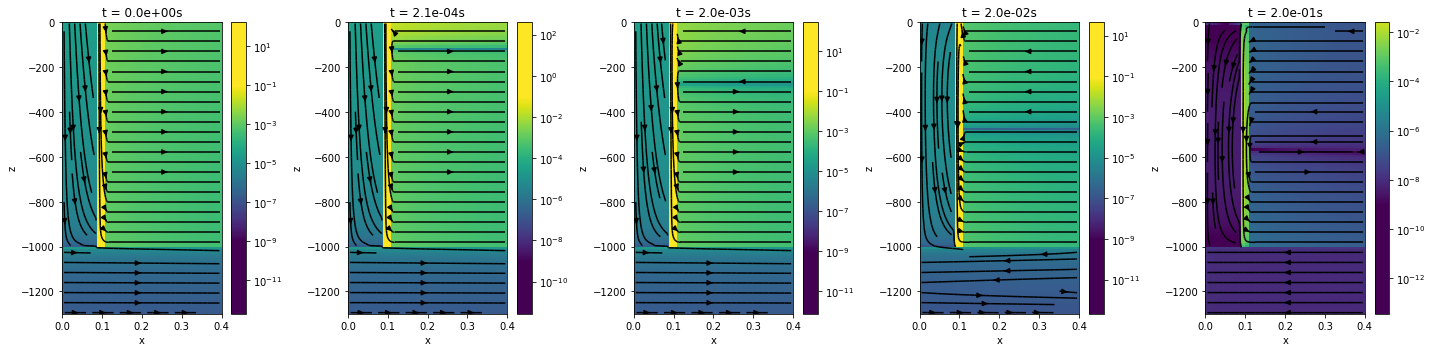

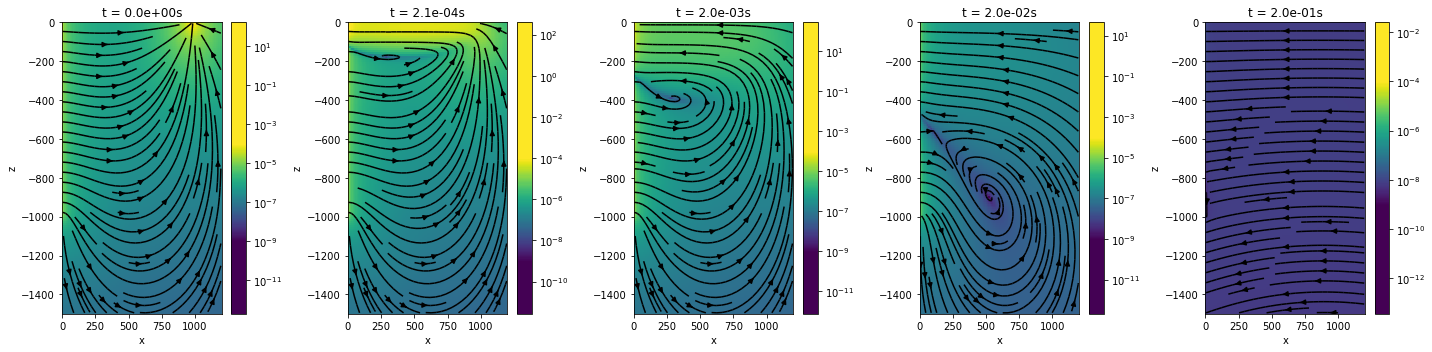

In [182]:
tinds = [0, 30, 48, 68, 88]
# tinds = [0, 50, 58, 68, 78]
# tinds = [0, 51, 58, 71, 78]

theta_ind = 5

for plotopts in [plotopts_close, plotopts_far]: 
    fig, ax = plt.subplots(1, len(tinds), figsize=(4*len(tinds), 5)) #, dpi=400) 

    for a, tind in zip(ax, tinds): 
        plotCurrents(
            tind=tind, theta_ind=theta_ind, simulation='3D', ax=a, plotopts=plotopts
        )
        a.set_title("t = {:1.1e}s".format(sim3D.prob.times[tind]))

    plt.tight_layout()
    plt.show()


In [17]:
# plot the casing currents through time 

Ix, Iz = casingSimulations.physics.CasingCurrents(
    fields
)

In [ ]:
Ix, Iz = casingSimulations.physics.CasingCurrents